# 1.1 Dataset Exploration (15/100 points)

As a starting point, analyze the provided data. Summarize the class distribution, the lengths of time
series, and basic descriptive statistics. In particular, report any characteristics that could be used
to deduce which class a time series belongs to. After analyzing the data characteristics, construct a
validation split from your training data that reflects the characteristics of the full training data. In
the report, justify your selection.

<b>Expected Results:</b> Summarize the data characteristics, visualize ECG time series of the individual
classes, and explain the differences between classes by utilizing the collected statistics. Finally, provide
the code to select a validation subset of the training data.

### Step 0: Dependency Check

Before running any code for this exercise, you need to make sure the necessary dependencies are installed.
You can do this by running the below cell, which is a shell script.

If you don't want to run a script on your local machine, you can install the below packages manually:

Core Dependencies:
- numpy>=1.20.0
- pandas>=1.3.0
- scipy>=1.7.0
- scikit-learn>=1.0.0
- joblib>=1.0.0

Deep Learning Dependencies:
- tensorflow>=2.8.0
- keras>=2.8.0

Visualization Dependencies:
- matplotlib>=3.5.0
- seaborn>=0.11.0

Biomedical Dependencies:
- wfdb>=3.4.0

Utilities:
- tqdm>=4.62.0

In [ ]:
# Runs a script to automatically install dependencies
# Please read the script before running it
!python3 ../dependencies.py

### Step 1: Parse the binary files

In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)
import utils
import numpy as np

In [2]:
X_train = utils.read_binary_file("../dataset/X_train.bin")
X_test = utils.read_binary_file("../dataset/X_test.bin")

### Step 2: Load labels and inspect class distribution

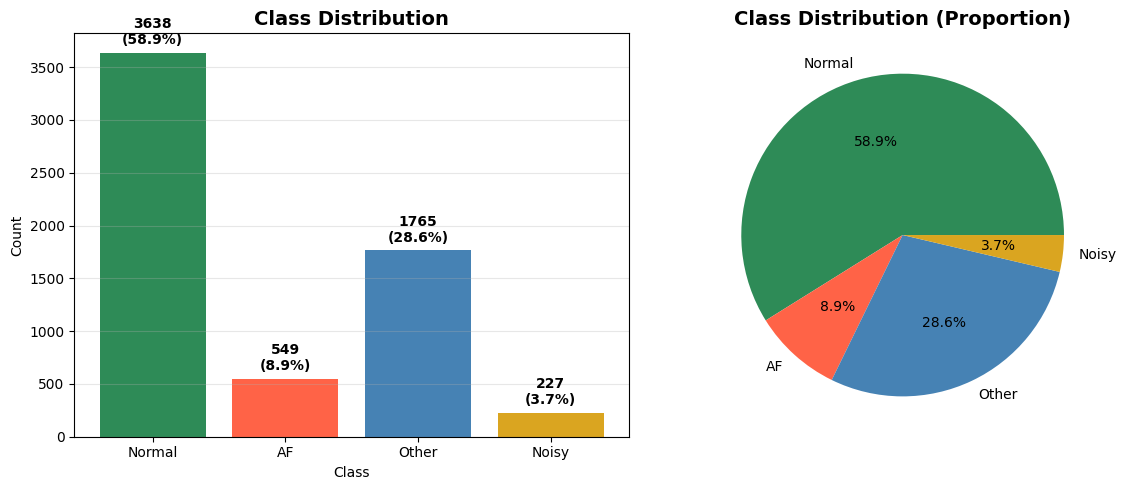

Dataset Summary:
Total samples: 6179

Class distribution:
  Normal: 3638 samples (58.9%)
  AF: 549 samples (8.9%)
  Other: 1765 samples (28.6%)
  Noisy: 227 samples (3.7%)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

y_train = pd.read_csv("../dataset/y_train.csv", header=None)[0]

# Class distribution
class_counts = y_train.value_counts().sort_index()
class_names = {0: 'Normal', 1: 'AF', 2: 'Other', 3: 'Noisy'}

plt.figure(figsize=(12, 5))

# Bar plot
plt.subplot(1, 2, 1)
bars = plt.bar(range(4), class_counts.values, color=['#2E8B57', '#FF6347', '#4682B4', '#DAA520'])
plt.title("Class Distribution", fontsize=14, fontweight='bold')
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=range(4), labels=[class_names[i] for i in range(4)])
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 50,
             f'{int(height)}\n({height/len(y_train)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

# Pie chart
plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=[class_names[i] for i in range(4)], 
        autopct='%1.1f%%', colors=['#2E8B57', '#FF6347', '#4682B4', '#DAA520'])
plt.title("Class Distribution (Proportion)", fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("Dataset Summary:")
print(f"Total samples: {len(y_train)}")
print("\nClass distribution:")
for i in range(4):
    count = class_counts[i]
    percentage = count / len(y_train) * 100
    print(f"  {class_names[i]}: {count} samples ({percentage:.1f}%)")

### Step 3: Length distribution of time series

/var/folders/nc/0rk_2jld2sv25tgq4mndv17w0000gn/T/ipykernel_6177/2548141659.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_lengths, x='Class', y='Length', palette=colors)


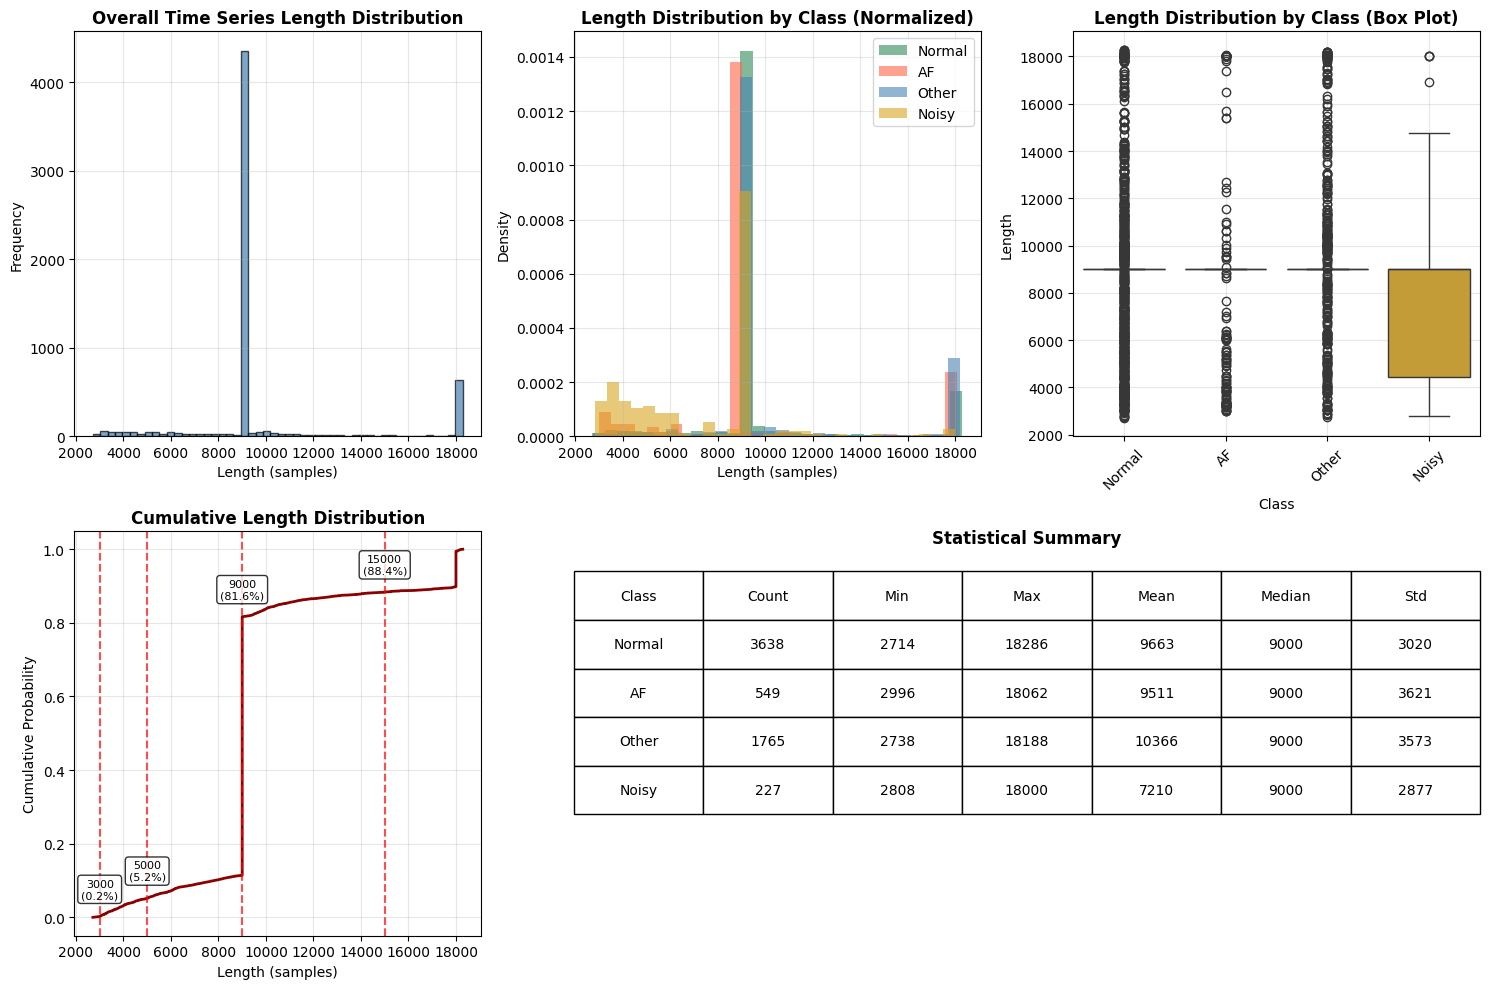

Overall Time Series Length Statistics:
  Min length: 2,714 samples
  Max length: 18,286 samples
  Mean length: 9760 samples
  Median length: 9000 samples
  Std deviation: 3292 samples
  25th percentile: 9000 samples
  75th percentile: 9000 samples

Data Processing Considerations:
  Sequences > 10,000 samples: 1002 (16.2%)
  Sequences > 15,000 samples: 719 (11.6%)
  Length variation (max/min ratio): 6.7x


In [4]:
lengths = [len(signal) for signal in X_train]

plt.figure(figsize=(15, 10))

# Overall length distribution
plt.subplot(2, 3, 1)
plt.hist(lengths, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
plt.title("Overall Time Series Length Distribution", fontweight='bold')
plt.xlabel("Length (samples)")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)

# Length distribution by class
plt.subplot(2, 3, 2)
colors = ['#2E8B57', '#FF6347', '#4682B4', '#DAA520']
for cls in range(4):
    class_indices = y_train[y_train == cls].index
    class_lengths = [lengths[i] for i in class_indices]
    plt.hist(class_lengths, bins=30, alpha=0.6, label=class_names[cls], 
             color=colors[cls], density=True)

plt.title("Length Distribution by Class (Normalized)", fontweight='bold')
plt.xlabel("Length (samples)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)

# Box plot of lengths by class
plt.subplot(2, 3, 3)
class_lengths_list = []
class_labels = []
for cls in range(4):
    class_indices = y_train[y_train == cls].index
    class_lengths = [lengths[i] for i in class_indices]
    class_lengths_list.extend(class_lengths)
    class_labels.extend([class_names[cls]] * len(class_lengths))

df_lengths = pd.DataFrame({'Length': class_lengths_list, 'Class': class_labels})
sns.boxplot(data=df_lengths, x='Class', y='Length', palette=colors)
plt.title("Length Distribution by Class (Box Plot)", fontweight='bold')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# Cumulative distribution
plt.subplot(2, 3, 4)
sorted_lengths = np.sort(lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
plt.plot(sorted_lengths, cumulative, linewidth=2, color='darkred')
plt.title("Cumulative Length Distribution", fontweight='bold')
plt.xlabel("Length (samples)")
plt.ylabel("Cumulative Probability")
plt.grid(alpha=0.3)

# Add vertical lines for common thresholds
for threshold in [3000, 5000, 9000, 15000]:
    cum_prob = np.sum(np.array(lengths) <= threshold) / len(lengths)
    plt.axvline(threshold, color='red', linestyle='--', alpha=0.7)
    plt.text(threshold, cum_prob + 0.05, f'{threshold}\n({cum_prob:.1%})', 
             ha='center', fontsize=8, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Length statistics by class
plt.subplot(2, 3, (5, 6))
plt.axis('off')

stats_text = "Length Statistics by Class:\n\n"
stats_data = []

for cls in range(4):
    class_indices = y_train[y_train == cls].index
    class_lengths = [lengths[i] for i in class_indices]
    
    stats_data.append({
        'Class': class_names[cls],
        'Count': len(class_lengths),
        'Min': min(class_lengths),
        'Max': max(class_lengths),
        'Mean': np.mean(class_lengths),
        'Median': np.median(class_lengths),
        'Std': np.std(class_lengths)
    })

stats_df = pd.DataFrame(stats_data)
stats_df['Mean'] = stats_df['Mean'].round(0).astype(int)
stats_df['Median'] = stats_df['Median'].round(0).astype(int)
stats_df['Std'] = stats_df['Std'].round(0).astype(int)

# Create a table
table_data = []
for _, row in stats_df.iterrows():
    table_data.append([row['Class'], row['Count'], row['Min'], row['Max'], 
                      row['Mean'], row['Median'], row['Std']])

table = plt.table(cellText=table_data,
                 colLabels=['Class', 'Count', 'Min', 'Max', 'Mean', 'Median', 'Std'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0.3, 1, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

plt.title("Statistical Summary", fontweight='bold', y=0.95)

plt.tight_layout()
plt.show()

# Overall summary stats
print("Overall Time Series Length Statistics:")
print(f"  Min length: {min(lengths):,} samples")
print(f"  Max length: {max(lengths):,} samples")
print(f"  Mean length: {np.mean(lengths):.0f} samples")
print(f"  Median length: {np.median(lengths):.0f} samples")
print(f"  Std deviation: {np.std(lengths):.0f} samples")
print(f"  25th percentile: {np.percentile(lengths, 25):.0f} samples")
print(f"  75th percentile: {np.percentile(lengths, 75):.0f} samples")

# Check for potential data processing considerations
print(f"\nData Processing Considerations:")
print(f"  Sequences > 10,000 samples: {np.sum(np.array(lengths) > 10000)} ({np.sum(np.array(lengths) > 10000)/len(lengths)*100:.1f}%)")
print(f"  Sequences > 15,000 samples: {np.sum(np.array(lengths) > 15000)} ({np.sum(np.array(lengths) > 15000)/len(lengths)*100:.1f}%)")
print(f"  Length variation (max/min ratio): {max(lengths)/min(lengths):.1f}x")

###  Step 4: Visualize example ECGs from each class

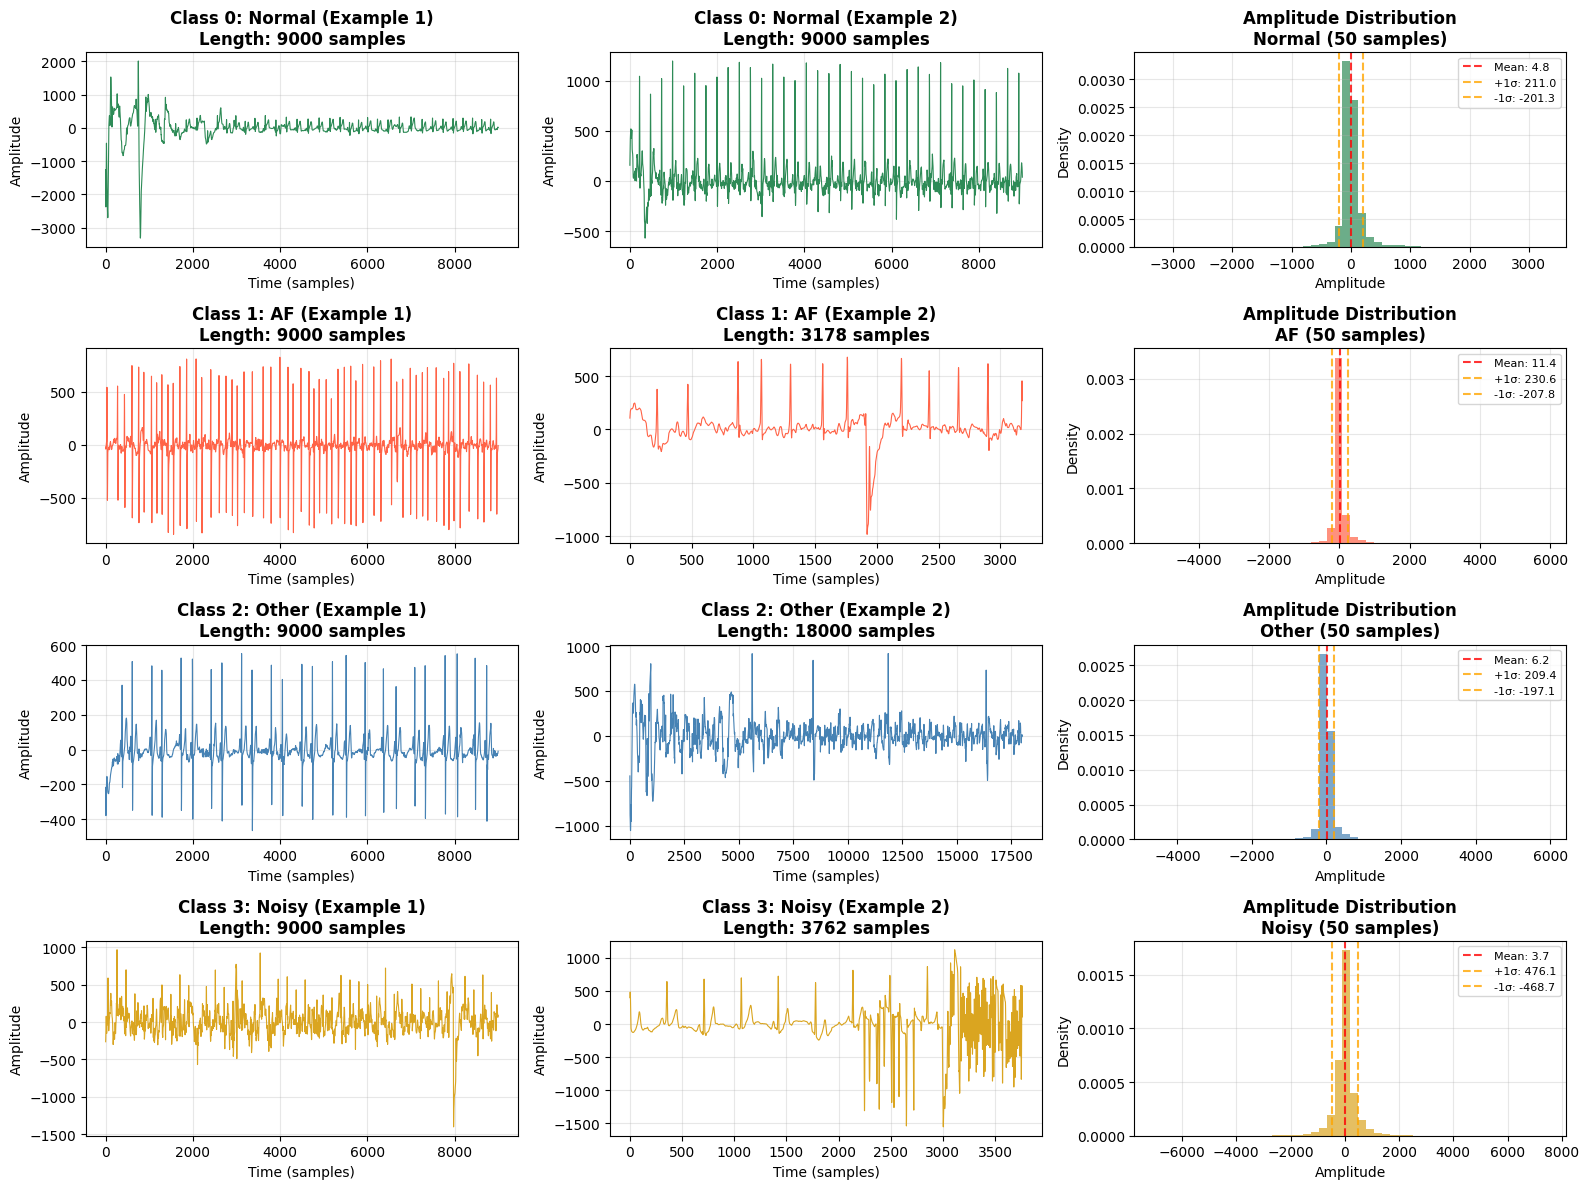

Signal Characteristics by Class:

Normal (Class 0):
  Amplitude range: [-3960.0, 4958.0]
  Mean amplitude: 7.6 ± 218.0
  Mean signal energy: 4.77e+08
  Mean signal variability: 195.6
  Sample count: 3638

AF (Class 1):
  Amplitude range: [-5277.0, 5897.0]
  Mean amplitude: 10.3 ± 211.3
  Mean signal energy: 4.35e+08
  Mean signal variability: 192.7
  Sample count: 549

Other (Class 2):
  Amplitude range: [-5615.0, 6410.0]
  Mean amplitude: 4.9 ± 219.0
  Mean signal energy: 4.82e+08
  Mean signal variability: 191.2
  Sample count: 1765

Noisy (Class 3):
  Amplitude range: [-7030.0, 7440.0]
  Mean amplitude: 4.1 ± 499.8
  Mean signal energy: 1.81e+09
  Mean signal variability: 445.9
  Sample count: 227


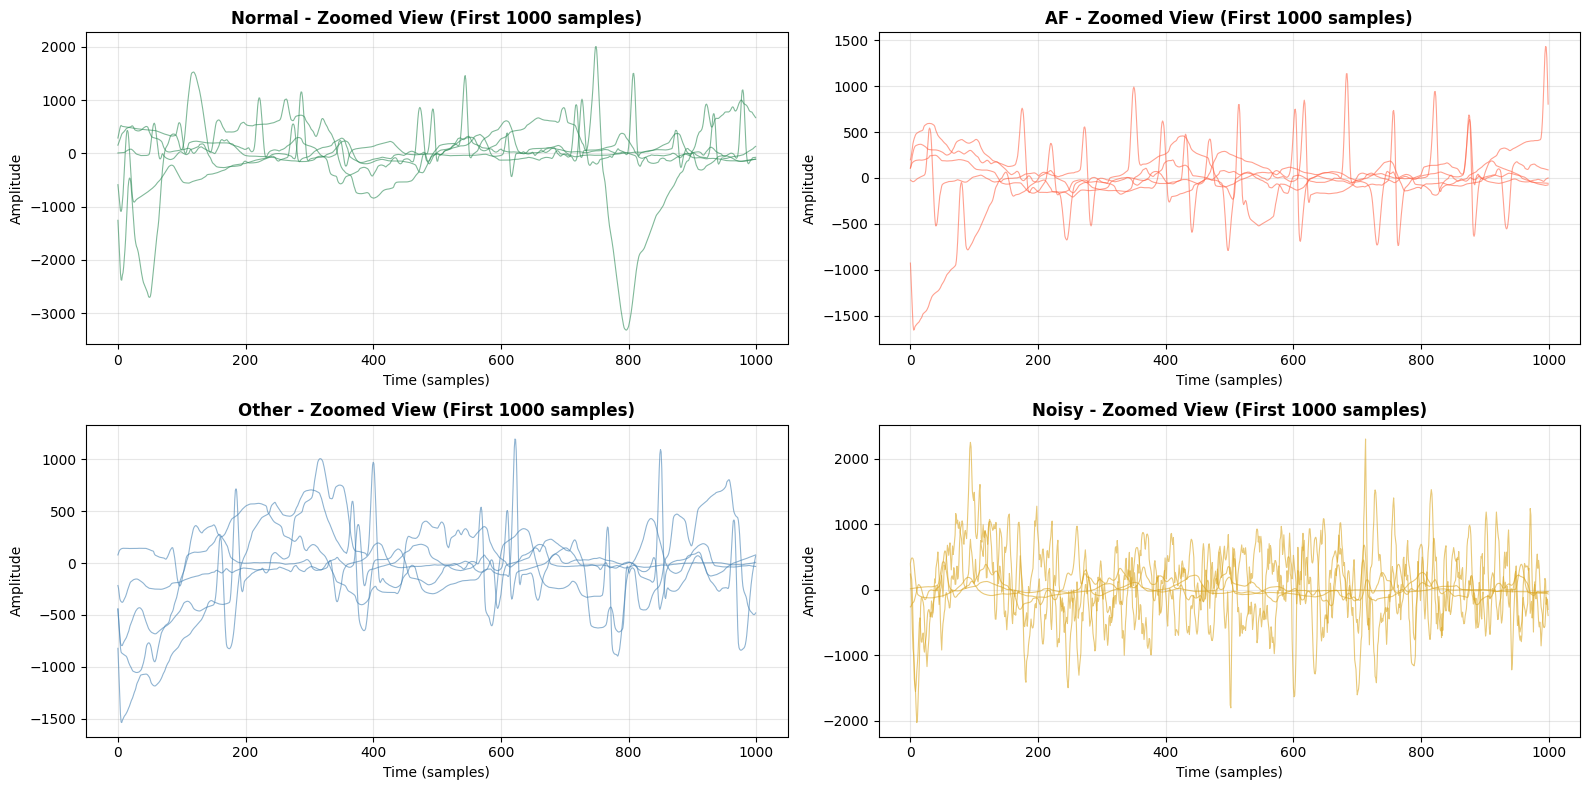

In [5]:
plt.figure(figsize=(16, 12))

# Show 2 examples per class
for cls in range(4):
    class_indices = y_train[y_train == cls].index
    
    # First example
    idx1 = class_indices[0]
    plt.subplot(4, 3, cls * 3 + 1)
    signal1 = X_train[idx1]
    plt.plot(signal1, color=colors[cls], linewidth=0.8)
    plt.title(f"Class {cls}: {class_names[cls]} (Example 1)\nLength: {len(signal1)} samples", fontweight='bold')
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.3)
    
    # Second example
    idx2 = class_indices[1] if len(class_indices) > 1 else class_indices[0]
    plt.subplot(4, 3, cls * 3 + 2)
    signal2 = X_train[idx2]
    plt.plot(signal2, color=colors[cls], linewidth=0.8)
    plt.title(f"Class {cls}: {class_names[cls]} (Example 2)\nLength: {len(signal2)} samples", fontweight='bold')
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.3)
    
    # Statistical analysis of the class
    plt.subplot(4, 3, cls * 3 + 3)
    class_signals = [X_train[i] for i in class_indices[:50]]  # Use first 50 for analysis
    
    # Calculate amplitude statistics
    all_amplitudes = np.concatenate(class_signals)
    
    plt.hist(all_amplitudes, bins=50, alpha=0.7, color=colors[cls], density=True)
    plt.title(f"Amplitude Distribution\n{class_names[cls]} (50 samples)", fontweight='bold')
    plt.xlabel("Amplitude")
    plt.ylabel("Density")
    plt.grid(alpha=0.3)
    
    # Add statistics text
    mean_amp = np.mean(all_amplitudes)
    std_amp = np.std(all_amplitudes)
    plt.axvline(mean_amp, color='red', linestyle='--', alpha=0.8, label=f'Mean: {mean_amp:.1f}')
    plt.axvline(mean_amp + std_amp, color='orange', linestyle='--', alpha=0.8, label=f'+1σ: {mean_amp + std_amp:.1f}')
    plt.axvline(mean_amp - std_amp, color='orange', linestyle='--', alpha=0.8, label=f'-1σ: {mean_amp - std_amp:.1f}')
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Additional detailed analysis
print("Signal Characteristics by Class:")
print("=" * 50)

for cls in range(4):
    class_indices = y_train[y_train == cls].index
    class_signals = [X_train[i] for i in class_indices[:100]]  # Analyze first 100 samples
    
    # Calculate various statistics
    all_amplitudes = np.concatenate(class_signals)
    mean_amp = np.mean(all_amplitudes)
    std_amp = np.std(all_amplitudes)
    min_amp = np.min(all_amplitudes)
    max_amp = np.max(all_amplitudes)
    
    # Calculate mean signal energy
    energies = [np.sum(np.square(signal)) for signal in class_signals]
    mean_energy = np.mean(energies)
    
    # Calculate signal variability (coefficient of variation)
    signal_stds = [np.std(signal) for signal in class_signals]
    mean_signal_std = np.mean(signal_stds)
    
    print(f"\n{class_names[cls]} (Class {cls}):")
    print(f"  Amplitude range: [{min_amp:.1f}, {max_amp:.1f}]")
    print(f"  Mean amplitude: {mean_amp:.1f} ± {std_amp:.1f}")
    print(f"  Mean signal energy: {mean_energy:.2e}")
    print(f"  Mean signal variability: {mean_signal_std:.1f}")
    print(f"  Sample count: {len(class_indices)}")

# Show a zoomed-in view of each class for pattern analysis
plt.figure(figsize=(16, 8))
zoom_samples = 1000  # Show first 1000 samples

for cls in range(4):
    plt.subplot(2, 2, cls + 1)
    class_indices = y_train[y_train == cls].index
    
    # Plot multiple signals overlaid
    for i in range(min(5, len(class_indices))):  # Show up to 5 examples
        signal = X_train[class_indices[i]]
        zoom_signal = signal[:min(zoom_samples, len(signal))]
        plt.plot(zoom_signal, alpha=0.6, linewidth=0.8, color=colors[cls])
    
    plt.title(f"{class_names[cls]} - Zoomed View (First {zoom_samples} samples)", fontweight='bold')
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Step 5: Create a stratified train/validation split

Split Summary:
  Original dataset: 6179 samples
  Training set: 4943 samples (80.0%)
  Validation set: 1236 samples (20.0%)

Class Distribution Verification:
 Class Original (%) Train (%) Val (%)  Train Count  Val Count
Normal         58.9      58.9    58.9         2910        728
    AF          8.9       8.9     8.9          439        110
 Other         28.6      28.6    28.6         1412        353
 Noisy          3.7       3.7     3.6          182         45


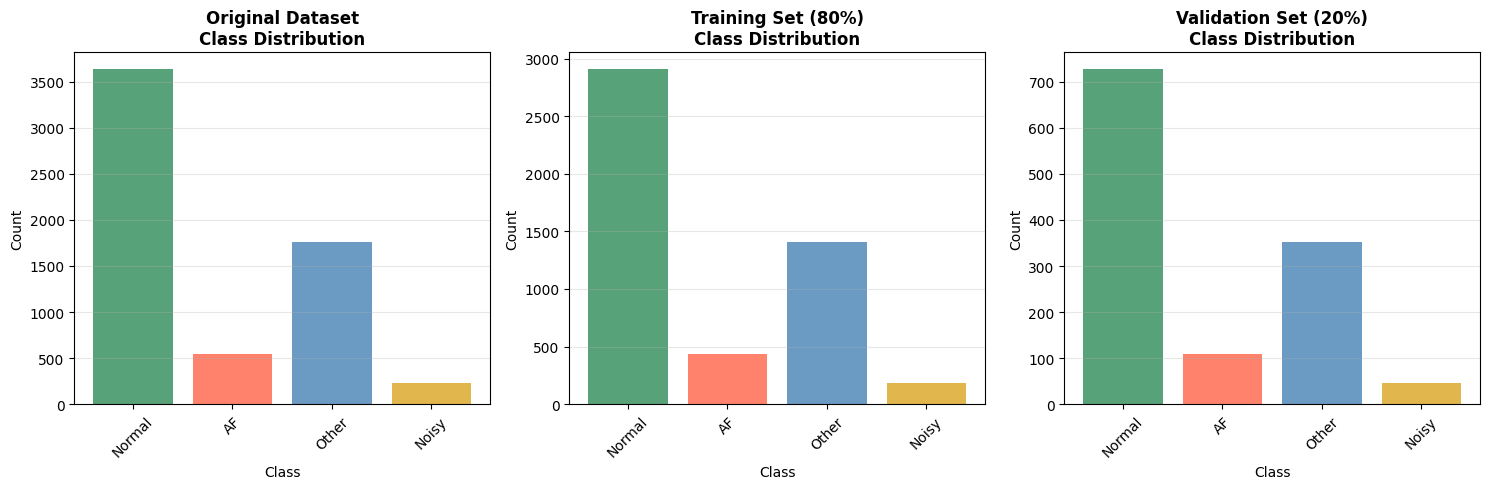

/var/folders/nc/0rk_2jld2sv25tgq4mndv17w0000gn/T/ipykernel_6177/3954421147.py:101: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_for_box, labels=['Training', 'Validation'])


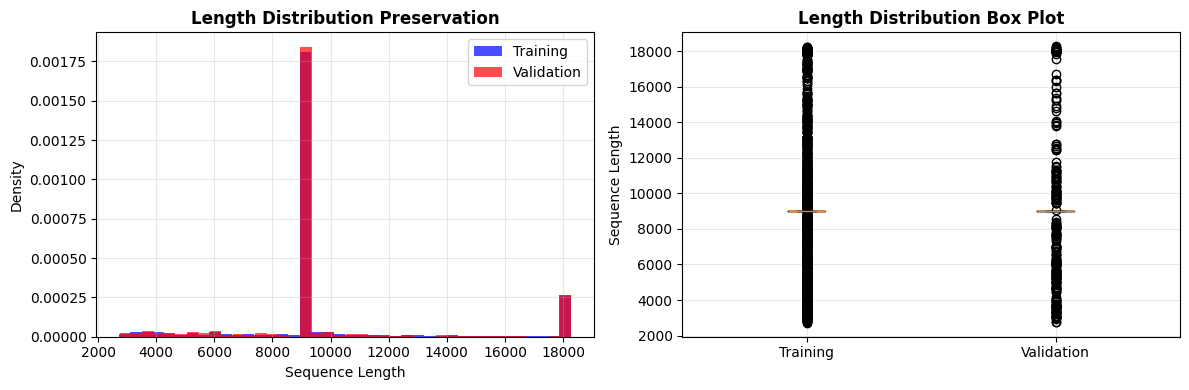


Length Statistics Comparison:
Training set - Mean: 9789, Std: 3304
Validation set - Mean: 9646, Std: 3240
Statistical difference test (KS test p-value): 0.6041
✅ Length distributions are statistically similar (p > 0.05)


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming class_names and colors are defined earlier in the code
# class_names = ['Class0', 'Class1', 'Class2', 'Class3']
# colors = ['red', 'blue', 'green', 'orange']

# Create stratified split to maintain class proportions
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(X_train, y_train))

X_train_split = [X_train[i] for i in train_idx]
y_train_split = y_train.iloc[train_idx].reset_index(drop=True)
X_val_split = [X_train[i] for i in val_idx]
y_val_split = y_train.iloc[val_idx].reset_index(drop=True)

print("Split Summary:")
print(f"  Original dataset: {len(X_train)} samples")
print(f"  Training set: {len(X_train_split)} samples ({len(X_train_split)/len(X_train)*100:.1f}%)")
print(f"  Validation set: {len(X_val_split)} samples ({len(X_val_split)/len(X_train)*100:.1f}%)")

# Verify stratification worked correctly
print("\nClass Distribution Verification:")
print("=" * 50)

original_dist = y_train.value_counts(normalize=True).sort_index()
train_dist = y_train_split.value_counts(normalize=True).sort_index()
val_dist = y_val_split.value_counts(normalize=True).sort_index()

comparison_data = []
for cls in range(4):
    comparison_data.append({
        'Class': class_names[cls],
        'Original (%)': f"{original_dist[cls]*100:.1f}",
        'Train (%)': f"{train_dist[cls]*100:.1f}",
        'Val (%)': f"{val_dist[cls]*100:.1f}",
        'Train Count': y_train_split.value_counts().sort_index()[cls],
        'Val Count': y_val_split.value_counts().sort_index()[cls]
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Visualize the split
plt.figure(figsize=(15, 5))

# Original distribution
plt.subplot(1, 3, 1)
original_counts = y_train.value_counts().sort_index()
plt.bar(range(4), original_counts.values, color=colors, alpha=0.8)
plt.title("Original Dataset\nClass Distribution", fontweight='bold')
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(4), [class_names[i] for i in range(4)], rotation=45)
plt.grid(axis='y', alpha=0.3)

# Training set distribution
plt.subplot(1, 3, 2)
train_counts = y_train_split.value_counts().sort_index()
plt.bar(range(4), train_counts.values, color=colors, alpha=0.8)
plt.title("Training Set (80%)\nClass Distribution", fontweight='bold')
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(4), [class_names[i] for i in range(4)], rotation=45)
plt.grid(axis='y', alpha=0.3)

# Validation set distribution
plt.subplot(1, 3, 3)
val_counts = y_val_split.value_counts().sort_index()
plt.bar(range(4), val_counts.values, color=colors, alpha=0.8)
plt.title("Validation Set (20%)\nClass Distribution", fontweight='bold')
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(range(4), [class_names[i] for i in range(4)], rotation=45)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Check length distribution preservation
train_lengths = [len(X_train_split[i]) for i in range(len(X_train_split))]
val_lengths = [len(X_val_split[i]) for i in range(len(X_val_split))]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_lengths, bins=40, alpha=0.7, label='Training', color='blue', density=True)
plt.hist(val_lengths, bins=40, alpha=0.7, label='Validation', color='red', density=True)
plt.title("Length Distribution Preservation", fontweight='bold')
plt.xlabel("Sequence Length")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Box plot comparison
data_for_box = [train_lengths, val_lengths]
plt.boxplot(data_for_box, labels=['Training', 'Validation'])
plt.title("Length Distribution Box Plot", fontweight='bold')
plt.ylabel("Sequence Length")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nLength Statistics Comparison:")
print(f"Training set - Mean: {np.mean(train_lengths):.0f}, Std: {np.std(train_lengths):.0f}")
print(f"Validation set - Mean: {np.mean(val_lengths):.0f}, Std: {np.std(val_lengths):.0f}")
print(f"Statistical difference test (KS test p-value): {stats.ks_2samp(train_lengths, val_lengths)[1]:.4f}")

if stats.ks_2samp(train_lengths, val_lengths)[1] > 0.05:
    print("✅ Length distributions are statistically similar (p > 0.05)")
else:
    print("⚠️ Length distributions might be different (p ≤ 0.05)")

In [7]:
import joblib
import os
import numpy as np

# Create processed directory if it doesn't exist
os.makedirs("../processed", exist_ok=True)

# Save the splits
joblib.dump((X_train_split, y_train_split), "../processed/train_split.pkl")
joblib.dump((X_val_split, y_val_split), "../processed/val_split.pkl")

# Save additional metadata for model training
metadata = {
    'class_names': class_names,
    'class_counts_original': y_train.value_counts().sort_index().to_dict(),
    'class_counts_train': y_train_split.value_counts().sort_index().to_dict(),
    'class_counts_val': y_val_split.value_counts().sort_index().to_dict(),
    'length_stats': {
        'min': min(lengths),
        'max': max(lengths),
        'mean': np.mean(lengths),
        'median': np.median(lengths),
        'std': np.std(lengths)
    },
    'split_info': {
        'train_size': len(X_train_split),
        'val_size': len(X_val_split),
        'split_ratio': 0.8,
        'random_state': 42
    }
}

joblib.dump(metadata, "../processed/dataset_metadata.pkl")

print("✅ Files saved successfully:")
print("  - ../processed/train_split.pkl")
print("  - ../processed/val_split.pkl") 
print("  - ../processed/dataset_metadata.pkl")
print(f"\nDataset ready for model training!")
print(f"Training samples: {len(X_train_split)}")
print(f"Validation samples: {len(X_val_split)}")

✅ Files saved successfully:
  - ../processed/train_split.pkl
  - ../processed/val_split.pkl
  - ../processed/dataset_metadata.pkl

Dataset ready for model training!
Training samples: 4943
Validation samples: 1236
